In [1]:

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from statistics import pstdev
from scipy.fft import fftshift, ifft, fftfreq
import numpy as np
from scipy.signal.windows import tukey
import math
from scipy.interpolate import interp1d
from time import time as time
from time import strftime
from datetime import date
from scipy.signal import ShortTimeFFT
from scipy.signal import find_peaks, peak_widths
from scipy.stats import norm
from IPython.display import display, Latex
import re 
from scipy import optimize
from scipy.optimize import curve_fit
from matplotlib.patches import Rectangle
from scipy.interpolate import PchipInterpolator
import lmfit

from scipy.signal.windows import tukey

plt.rcParams.update({'font.size':15})


## Useful Functions


In [4]:
def FWHM(x,y):

    peak_centre =[]
    unit_widths=[]
    full_width_half_max=[]
    lefts_unit =[]
    rights_unit=[]
    lefts =[]
    rights=[]
    heights=[]
    
    dx = np.mean(np.diff(x))

    #print(dx)

    
    
    

    peak,peak_heights = find_peaks(y,distance =2,prominence= 0.3*np.max(y), height = 0.75)

    peak_y = peak_heights["peak_heights"]

    heights.append(peak_y)

    peak_centre.append(peak[0])

    widths =  peak_widths(y, peak_centre, rel_height =0.5)  

    #print(widths)
    
    unit_widths.append(widths[0])
    lefts_unit.append(widths[2])
    rights_unit.append(widths[3])

    for i in range(len(unit_widths)):

        fwhm = unit_widths[i] * dx
        #print(fwhm)
        left_pos = lefts_unit[i] *dx    
        right_pos = rights_unit[i] *dx   
        full_width_half_max.append(fwhm)
        lefts.append(left_pos)
        rights.append(right_pos)

   
    

    '''
    for i in range(len(full_width_half_max)):

        print('The peak has a FWHM of {0:.3f}fs with a LH crossing of {1:.3f}fs and a RH crossing of {2:.3f}fs'.format(float(full_width_half_max[i]), float(lefts[i]), float(rights[i])) ) 

    '''
    return full_width_half_max, lefts, rights, heights, dx, fwhm

def FWHM_2(x,y):
    peak =np.argmax(y)
    peak_val =y[peak]
    half_max = peak_val /2 

    # Left side
    left_region = y[:peak]
    if np.any(left_region <= half_max):
        y1 = np.where(left_region <= half_max)[0][-1]
        y0 = y1 + 1
        # linear interpolation for crossing
        x_left = x[y1] + (x[y0] - x[y1]) * (half_max - y[y1]) / (y[y0] - y[y1])
    else:
        return np.nan

    # Right side
    right_region = y[peak:]
    if np.any(right_region <= half_max):
        y1 = np.where(right_region <= half_max)[0][0] + peak
        y0 = y1 - 1
        x_right = x[y1] + (x[y0] - x[y1]) * (half_max - y[y1]) / (y[y0] - y[y1])
    else:
        return np.nan

    fwhm = x_right -x_left
    return fwhm
    

def linear_func(x,m,c):

    return x*m +c     


def FWHM(t, I):
    # Find peak
    peak = np.argmax(I)
    peak_val = I[peak]
    half = peak_val / 2

    # Left side
    left_region = I[:peak]
    if np.any(left_region <= half):
        i1 = np.where(left_region <= half)[0][-1]
        i0 = i1 + 1
        # linear interpolation for crossing
        t_left = t[i1] + (t[i0] - t[i1]) * (half - I[i1]) / (I[i0] - I[i1])
    else:
        return np.nan

    # Right side
    right_region = I[peak:]
    if np.any(right_region <= half):
        i1 = np.where(right_region <= half)[0][0] + peak
        i0 = i1 - 1
        t_right = t[i1] + (t[i0] - t[i1]) * (half - I[i1]) / (I[i0] - I[i1])
    else:
        return np.nan

    return t_right - t_left

def quad_func(x,a,b,c,d,e):
    y = a*x**4 + b*x**3 + c*x**2 +d*x + e 
    return y    




def GDD_from_time(target,p1,p2):

    GDD = (target -p2)/p1
    print('The GDD for a target pulse width of {0}fs is {1:.3f} fs^2'.format(target,GDD))
    return GDD

def time_from_GDD(target,p1,p2):
    tau = (p1*target) + p2
    print('The time for a target GDD of {0}fs^2 is {1:.3f} fs'.format(target,tau))
    return tau 

def gdd_from_time_poly(target,c5,c4,c3,c2,c1,c0,first_width):
    if target <= first_width: 
        target = first_width
        print('You have reached the TL limit of this pulse - the Target FWHM has been set to the TL limit')
        GDD = 0
        print('The GDD for a target pulse width of {0:.3f}fs is {1:.3f} fs^2'.format(target,GDD))
    else:
        GDD = c5*target**5 + c4*target**4 +c3*target**3 + c2*target**2 +c1*target + c0
        print('The GDD for a target pulse width of {0}fs is {1:.3f} fs^2'.format(target,GDD))
    return GDD

def time_from_GDD_poly(target,c5,c4,c3,c2,c1,c0,first_width):
    if target <= 0:
        
        print('You have reached the lower bound for this model hence we recover TL pulse')
        tau = first_width
        print('The time for a target GDD of {0}fs^2 is {1:.3f} fs'.format(target,tau))
    else: 
        tau = c5*target**5 + c4*target**4 +c3*target**3 + c2*target**2 +c1*target + c0
        print('The time for a target GDD of {0}fs^2 is {1:.3f} fs'.format(target,tau))
    return tau 

## The Function 

In [52]:
def gdd_vs_time_bandwidth(phases, bandwidths, lambda_c): 

    lambda0=  lambda_c

    num_points = 20000
    c = 2.998e8
    band_width_curve =[]

    for i in range(len(bandwidths)):
        #print('I am computing the {0}nm bandwidth curve'.format(bandwidths[i]))
        lambdas = np.linspace(lambda0 - 2*bandwidths[i], lambda0 + 2*bandwidths[i], num_points)
        sigma = bandwidths[i] / (2*np.sqrt(2*np.log(2)))
        I_lambda = np.exp(-0.5 * ((lambdas - lambda0) / sigma)**2)
        A_lambda = np.sqrt(I_lambda / np.max(I_lambda))

        # --- Normalize ---
        I_lambda /= np.max(I_lambda)
        omega = (2*np.pi*c / (lambdas * 1e-9))/1e15
        omega0 = (2*np.pi*c / (lambda0 * 1e-9))/1e15
        Omega = omega - omega0  # detuning from central frequency

        # Sort ascending for Fourier compatibility
        idx = np.argsort(Omega)
        omegas, I_omega = Omega[idx], I_lambda[idx]

        widths=[]
        for i in range(len(phases)):

            a2 = phases[i] # s^2, adjust to see broadening
            phase_data = -0.5*(a2 * (Omega)**2)  # 

            
            phi_interp = interp1d(Omega, phase_data, kind='cubic', fill_value=2000, bounds_error=False)
        
            delta_omega = (Omega.max()-Omega.min())/num_points
            Omega_uniform = Omega.min() + np.arange(num_points) *delta_omega
            #Omega_uniform = np.linspace(Omega.min(), Omega.max(), num_points)
            A_interp = interp1d(Omega, A_lambda, kind='cubic', fill_value=2000, bounds_error=False)
            phi_interp = interp1d(Omega, phase_data, kind='cubic', fill_value=2000, bounds_error=False)


            A_omega = A_interp(Omega_uniform)
            

            
            phi_omega = phi_interp(Omega_uniform)
            E_omega = A_omega * np.exp(1j * phi_omega)

            # --- Inverse Fourier Transform to time domain ---
            E_t = fftshift(ifft(fftshift(E_omega)))
            domega = Omega_uniform[1] - Omega_uniform[0]
            dt = 2*np.pi / (num_points * domega)
            t = dt * np.arange(-num_points/2, num_points/2)
            
            # --- Temporal intensity ---
            I_t = np.abs(E_t)**2
            I_t /= np.max(I_t)

            #full_width_half_max, lefts, rights, heights, dx,fwg = FWHM(t,I_t)
            fwg = FWHM_2(t,I_t)
            #print(full_width_half_max)
            widths.append(float(fwg))

        band_width_curve.append(widths)
        
    #print(band_width_curve)
    #print(len(band_width_curve))


    color = iter(plt.cm.rainbow(np.linspace(0, 1, len(band_width_curve))))
    cmap = plt.get_cmap('rainbow', len(band_width_curve))    
    
    
    
    
    plt.figure(figsize=(20,12))
    for i in range(len(band_width_curve)):
        c = next(color)
        plt.plot(phases, band_width_curve[i],color =c, label ='$\Delta\lambda$ ={0:.3f}nm'.format(bandwidths[i]))
    
    plt.xlabel("GDD \ $fs^2$")
    plt.ylabel("Temporal Width \ fs")
    plt.title("Temporal Width (FWHM) as a function of simulated applied GDD")
    plt.legend()
    #plt.xlim(0,1000)
    #plt.ylim(0,500)
    #plt.axhline(130)
    #plt.axvline(2800)

    title ='Temporal_fwhm_vs_applied_GDD_261125.png'
    #plt.savefig(title)
    plt.show()



    

    


<>:79: SyntaxWarning: invalid escape sequence '\D'
<>:81: SyntaxWarning: invalid escape sequence '\ '
<>:82: SyntaxWarning: invalid escape sequence '\ '
<>:79: SyntaxWarning: invalid escape sequence '\D'
<>:81: SyntaxWarning: invalid escape sequence '\ '
<>:82: SyntaxWarning: invalid escape sequence '\ '
/var/folders/ch/jpgfqsp91mq7dcm3hcx5l0vc0000gn/T/ipykernel_4693/1526867035.py:79: SyntaxWarning: invalid escape sequence '\D'
  plt.plot(phases, band_width_curve[i],color =c, label ='$\Delta\lambda$ ={0:.3f}nm'.format(bandwidths[i]))
/var/folders/ch/jpgfqsp91mq7dcm3hcx5l0vc0000gn/T/ipykernel_4693/1526867035.py:81: SyntaxWarning: invalid escape sequence '\ '
  plt.xlabel("GDD \ $fs^2$")
/var/folders/ch/jpgfqsp91mq7dcm3hcx5l0vc0000gn/T/ipykernel_4693/1526867035.py:82: SyntaxWarning: invalid escape sequence '\ '
  plt.ylabel("Temporal Width \ fs")


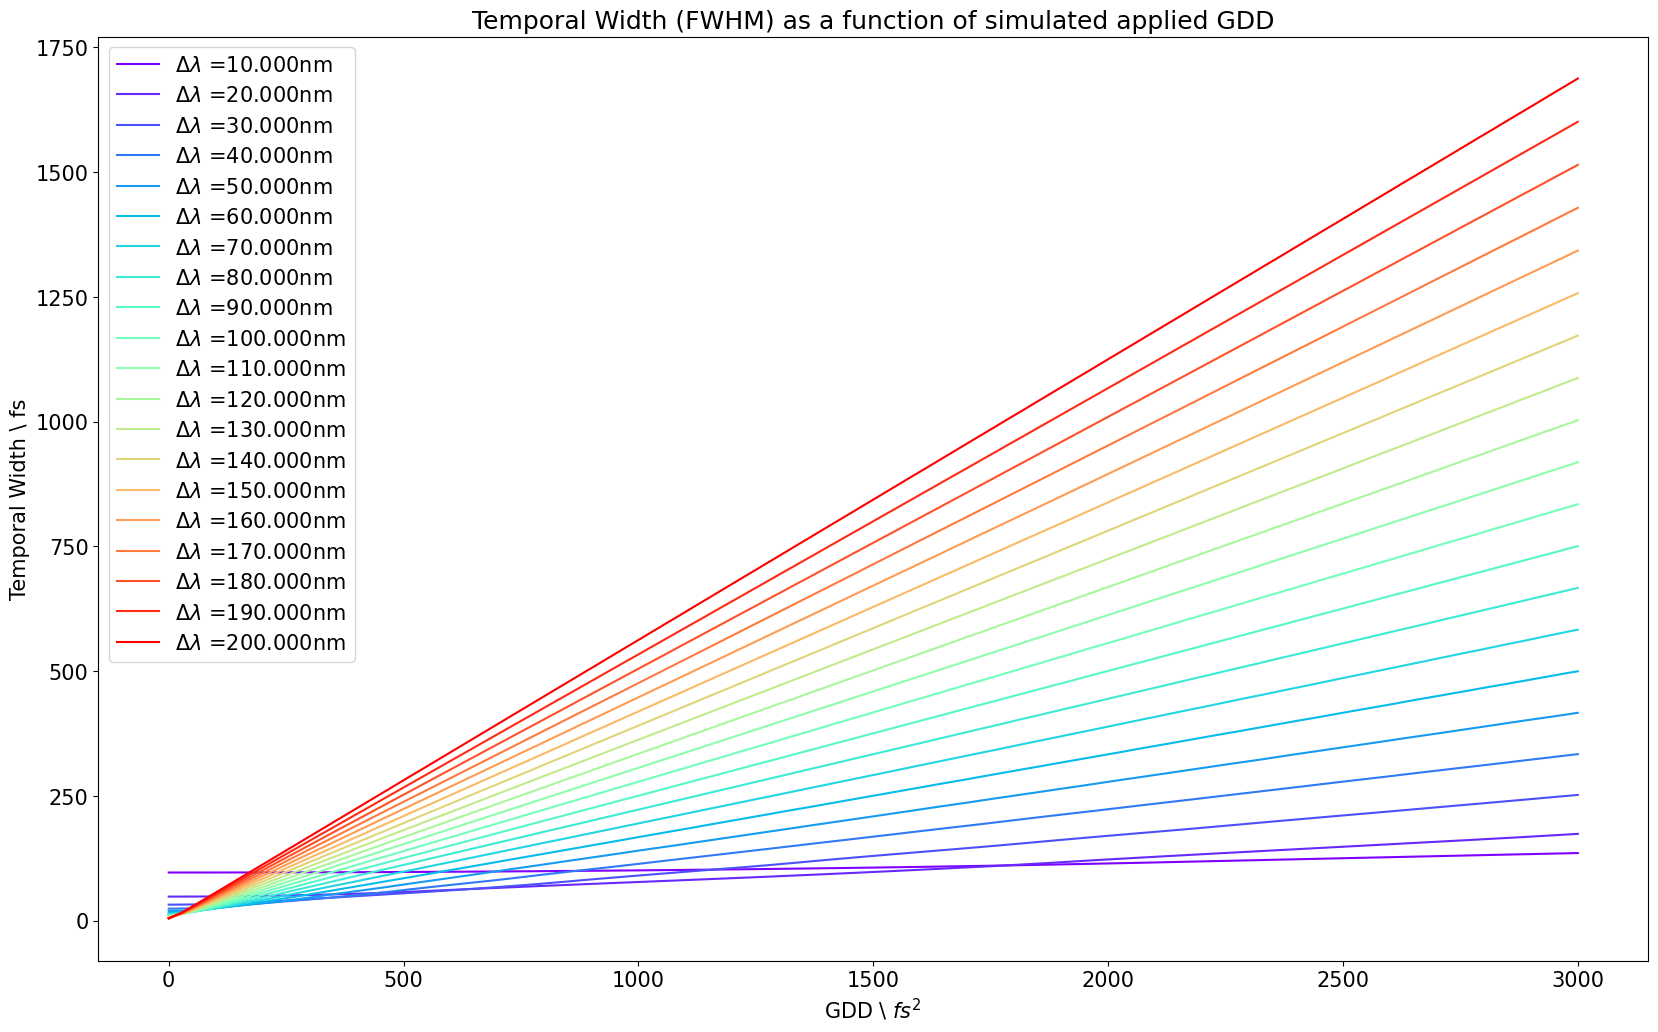

In [54]:
phases2 = np.linspace(0,3000, 100)
band_widths2 =np.linspace(10,200,20)


gdd_vs_time_bandwidth(phases2, band_widths2, 824.5)


